In [9]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph, add_law_beta_drives, rescale_pyr_mech
sns.set()


In [10]:
def law_2021_model():
    """Instantiate the beta modulated ERP network model.
    Returns
    -------
    net : Instance of Network object
        Network object used to store the model used in
        Law et al. 2021.
    See Also
    --------
    jones_2009_model
    Notes
    -----
    Model reproduces results from Law et al. 2021
    This model differs from the default network model in several
    parameters including
    1) Increased GABAb time constants on L2/L5 pyramidal cells
    2) Decrease L5_pyramidal -> L5_pyramidal nmda weight
    3) Modified L5_basket -> L5_pyramidal inhibition weights
    4) Removal of L5 pyramidal somatic and basal dendrite calcium channels
    5) Replace L2_basket -> L5_pyramidal GABAa connection with GABAb
    6) Addition of L5_basket -> L5_pyramidal distal connection
    """

    hnn_core_root = op.dirname(hnn_core.__file__)
    params_fname = op.join(hnn_core_root, 'param', 'default.json')
    params = read_params(params_fname)

    net = jones_2009_model(params)

    # Update biophysics (increase gabab duration of inhibition)
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau2'] = 200.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau2'] = 200.0

    # Decrease L5_pyramidal -> L5_pyramidal nmda weight
    net.connectivity[2]['nc_dict']['A_weight'] = 0.0004

    # Modify L5_basket -> L5_pyramidal inhibition
    net.connectivity[6]['nc_dict']['A_weight'] = 0.02  # gabaa
    net.connectivity[7]['nc_dict']['A_weight'] = 0.005  # gabab

    # Remove L5 pyramidal somatic and basal dendrite calcium channels
    for sec in ['soma', 'basal_1', 'basal_2', 'basal_3']:
        del net.cell_types['L5_pyramidal'].sections[
            sec].mechs['ca']

    # Remove L2_basket -> L5_pyramidal gabaa connection
    del net.connectivity[10]  # Original paper simply sets gbar to 0.0

    # Add L2_basket -> L5_pyramidal gabab connection
    delay = net.delay
    src_cell = 'L2_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 50.
    weight = 0.00005
    loc = 'distal'
    receptor = 'gabab'
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    # Add L5_basket -> L5_pyramidal distal connection
    # ("Martinotti-like recurrent tuft connection")
    src_cell = 'L5_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 70.
    loc = 'distal'
    receptor = 'gabaa'
    key = f'gbar_L5Basket_L5Pyr_{receptor}'
    weight = net._params[key]
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    return net

In [23]:
%%capture
depths = np.arange(-325, 2150, 100) 
electrode_pos = [(135, 135, dep) for dep in depths]
scaling_factors = [1, .8, .28]
#props = ['L', 'diam', 'Ra', 'cm']
props = ['L']
mech_edits = [('hh2', 'gkbar_hh2'), ('hh2', 'gnabar_hh2'), ('ca', 'gbar_ca'), ('cad', 'taur_cad'), ('kca', 'gbar_kca'), ('km', 'gbar_km'), ('cat', 'gbar_cat')]
pyr_cells = ['L2_pyramidal', 'L5_pyramidal']
omit_compartments = ['basal_1',  'basal_2',  'basal_3',  'soma']

net_list = list()
lfp_data = list()
dpl_list = list()
for scaling_factor in scaling_factors:
    # net = calcium_model()
    net = law_2021_model()
    net.add_electrode_array('shank1', electrode_pos)
    #add_supra_beta_drives(net, beta_start=200, strength=1)
    add_law_beta_drives(net, beta_start=200, strength=1.0)
    for prop in props:        
        if prop == 'cm':
            new_fctr = 1/scaling_factor
        else:
            new_fctr = scaling_factor
        rescale_pyr_morph(net=net, cell_types=pyr_cells, compartment_prop=prop, scaling_factor=new_fctr,
                          omit_compartment=omit_compartments)

    rescale_pyr_mech(net=net, cell_types=pyr_cells, compartment_mech=mech_edits, scaling_factor=new_fctr,
                        omit_compartment=omit_compartments)
                        
    with MPIBackend(n_procs=1):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]
    
    dpl.data['agg']  -= dpl.data['agg'][int(100/0.05)] # subtract baseline at 100 ms (assuming dt=0.05)
    net_list.append(net.copy())
    lfp_data.append(net.rec_arrays.copy())
    dpl_list.append(dpl.copy())

# for idx, dpl in enumerate(dpl_list):

#     fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6), constrained_layout=True)
#     plot_dipole(dpl, ax=axes[0], layer='agg', show=False)
#     net.cell_response.plot_spikes_hist(ax=axes[1], show=False)
#     net.cell_response.plot_spikes_raster(ax=axes[2], show=False)
    
#     #fig.savefig(f'apical_only_ca_model_beta_{scaling_factors[idx]}_dend.png')

# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 4), constrained_layout=True)
# plot_dipole([dpl.copy().smooth(30) for dpl in dpl_list], ax=axes, show=False)
# axes.legend(scaling_factors)
# #fig.savefig(f'apical_only_ca_model_beta_comparison.png')

In [25]:
depths

array([-325, -225, -125,  -25,   75,  175,  275,  375,  475,  575,  675,
        775,  875,  975, 1075, 1175, 1275, 1375, 1475, 1575, 1675, 1775,
       1875, 1975, 2075])

/home/ntolley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/ntolley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ntolley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using t

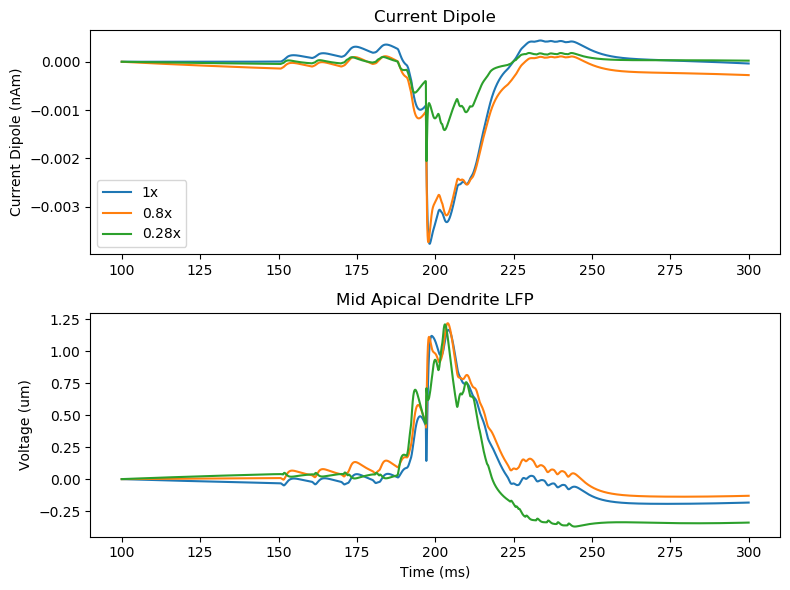

In [53]:
color = ['C0', 'C1', 'C2']
plt.figure(figsize=(8, 6))

contact_idx1_list = [10, 9, 4]
for idx in range(3):
    times = dpl_list[idx].times
    contact_idx1 = contact_idx1_list[idx]

    times_mask = np.logical_and(times < 300, times > 100)

    plt.subplot(2,1,1)
    plt.plot(times[times_mask], dpl_list[idx].data['agg'][times_mask], color=color[idx], label=f'{scaling_factors[idx]}x')
    plt.title(f'Current Dipole')
    plt.ylabel('Current Dipole (nAm)')
    plt.legend()


    plt.subplot(2,1,2)
    lfp1 = lfp_data[idx]['shank1'].voltages.squeeze()[contact_idx1, times_mask]
    plt.plot(times[times_mask], lfp1 - lfp1[0], color=color[idx])
    plt.title(f'Mid Apical Dendrite LFP')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (um)')

plt.tight_layout()
plt.savefig('final_figures/dipole_lfp_scale.eps')
plt.savefig('final_figures/dipole_lfp_scale.png')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


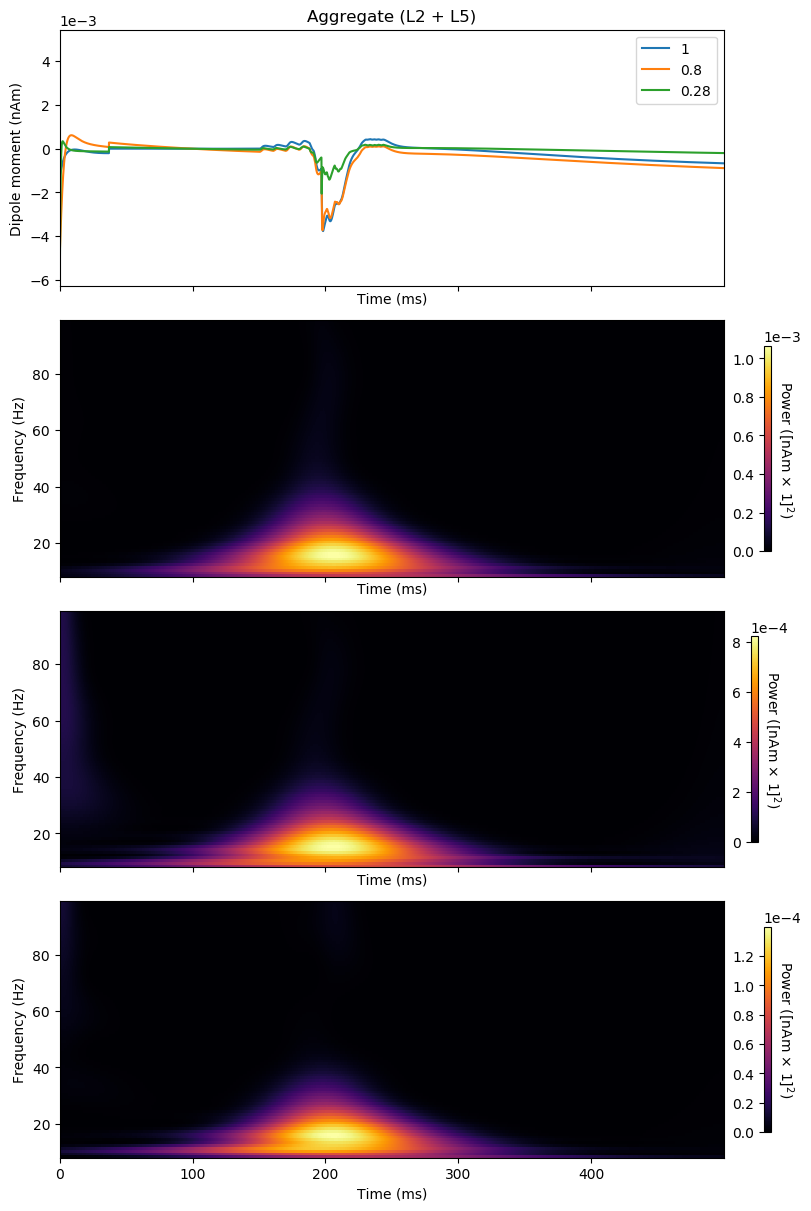

In [46]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 12), constrained_layout=True)
plot_dipole([dpl.copy() for dpl in dpl_list], ax=axes[0], show=False)
axes[0].legend(scaling_factors)
freqs = np.arange(8, 100)
for idx, dpl in enumerate(dpl_list):
    dpl.copy().plot_tfr_morlet(freqs, ax=axes[idx+1], show=False)
fig.savefig(f'final_figures/spectrogram_dipole_scale.eps')

In [47]:
fig.savefig(f'final_figures/spectrogram_dipole_scale.png')

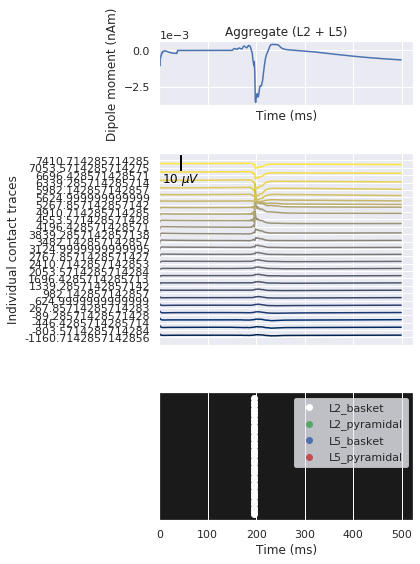

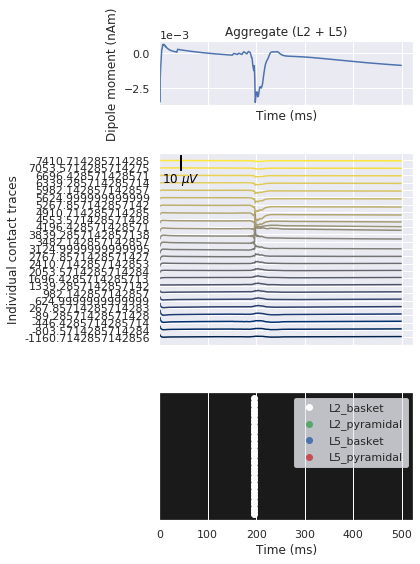

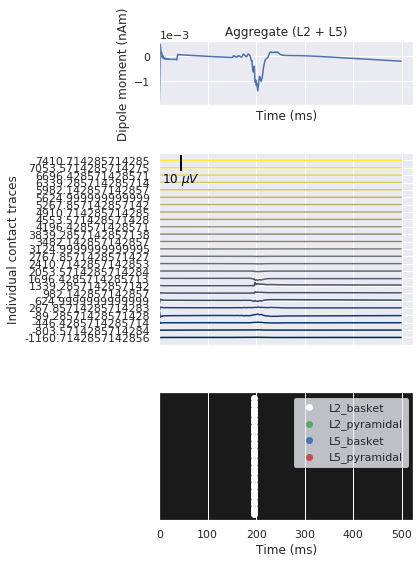

In [21]:
trial_idx = 0
res_idx = 0

window_len = 1  # ms
decimate = [5, 4]  # from 40k to 8k to 2k
for res_idx in range(3):
    net = net_list[res_idx]
    dpl = dpl_list[res_idx].copy()
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 8),
                            gridspec_kw={'height_ratios': [1, 3, 2]})

    # Then plot the aggregate dipole time series on its own axis
    dpl.copy().smooth(
        window_len=window_len).plot(ax=axs[0], decim=decimate,
                                    show=False)

    voltage_offset = 5  # the spacing between individual traces
    voltage_scalebar = 10  # can be different from offset
    # we can assign each electrode a unique color using a linear colormap
    colors = plt.get_cmap('cividis', len(electrode_pos))

    # use the same smoothing window on the LFP traces to allow comparison to dipole
    lfp_data[res_idx]['shank1'].copy().smooth(window_len=window_len).plot(
        ax=axs[1], contact_labels=depths, color=colors, decim=decimate, show=False,
        voltage_offset=voltage_offset, voltage_scalebar=voltage_scalebar)

    axs[1].grid(True, which='major', axis='x')
    axs[1].set_xlabel('')
    # Finally, add the spike raster to the bottom subplot
    net.cell_response.plot_spikes_raster(ax=axs[2], show=False)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'lfp_array_scale{scaling_factor[res_idx]}.eps')

In [15]:
lfp_data

[{'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa | 1 trials, 1001 times>},
 {'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa | 1 trials, 1001 times>},
 {'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa | 1 trials, 1001 times>}]